# forword AlphaPose 

## Step 1
### 数据预处理 

## Step 2
### 人体检测 

## Step 3
### 关键点检测 

## Step 4
### 后处理，生成结果图片

In [7]:
import torch

In [8]:
import torch 
from torch.autograd import Variable 
import torch.nn.functional as F 
import torchvision.transforms as transforms 

import torch.nn as nn
import torch.utils.data 
import numpy as np 

import os 
import sys 
import time 

from opt import opt 
from dataloader import ImageLoader, DetectionLoader, DetectionProcessor, DataWriter, Mscoco 
from yolo.util import write_results, dynamic_write_results 
from SPPE.src.main_fast_inference import * 
from fn import getTime 

from pPose_nms import pose_nms, write_json 
from yolo.darknet import Darknet 

from yolo.preprocess import prep_frame, prep_image, inp_to_image
from SPPE.src.utils.img import load_image, cropBox, im_to_torch
import cv2
from dataloader import crop_from_dets
from fn import vis_frame, vis_frame_fast
import matplotlib.pyplot as plt

from pPose_nms import pose_nms
from SPPE.src.utils.eval import getPrediction 

# Step 1
## 图片预处理 

In [9]:
from opt import opt
import os
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w / img_w, h / img_h))
    new_h = int(img_h * min(w / img_w, h / img_h))
    resized_image = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h - new_h) // 2:(h - new_h) // 2 + new_h, (w - new_w) // 2:(w - new_w) // 2 + new_w, :] = resized_image

    return canvas


def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network.

    Returns a Variable
    """
    orig_im = cv2.imread(img)
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:, :, ::-1].transpose((2, 0, 1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

args = opt 
mode = args.mode #'normal'
args.dataset = 'coco'
input_path = 'images/input'
for root, dirs, files in os.walk(input_path):
    im_names = files 
    
img = [] 
orig_img = [] 
im_name = []
im_dim_list = [] 
# input dimension
inp_dim = int(args.inp_dim) # 608



num = 3




im_name_k = im_names[num] 
im_name_k = os.path.join(root, im_name_k) 
img_k, orig_img_k, im_dim_list_k = prep_image(im_name_k, inp_dim) 


img.append(img_k) 
orig_img.append(orig_img_k)
im_name.append(im_names[num]) 
im_dim_list.append(im_dim_list_k)

In [10]:
# img[0].shape
# img = torch.cat(img)
# img.shape
# img.dtype

# Step 2
## 人体检测  

In [11]:
# 获得人体检测框 
det_model = Darknet("yolo/cfg/yolov3-spp.cfg") 
det_model.load_weights('models/yolo/yolov3-spp.weights')
det_model.net_info['height'] = 608
det_inp_dim = 608

det_model.cuda()
det_model.eval()


with torch.no_grad():
    img = torch.cat(img)
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1, 2)
    img = img.cuda()
    img.shape
    # prediction
    prediction = det_model(img, CUDA=True) 
    # NMS process 
    dets = dynamic_write_results(prediction, opt.confidence, opt.num_classes, nms=True, nms_conf=opt.nms_thesh) 

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): Batch

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): Batch

torch.Size([1, 3, 608, 608])

In [12]:
dets

tensor([[   0.0000,  249.6526,  190.4018,  337.0158,  426.0182,    0.9786,
            0.9997,    0.0000],
        [   0.0000,  221.3023,  176.8969,  283.1271,  345.9514,    0.9505,
            0.9999,    0.0000]], device='cuda:0')

In [13]:
with torch.no_grad():
    dets = dets.cpu()
    im_dim_list = torch.index_select(im_dim_list,0,dets[:,0].long())
    scaling_factor = torch.min(det_inp_dim/im_dim_list, 1)[0].view(-1,1) 
    dets[:, [1,3]] -= (det_inp_dim - scaling_factor * im_dim_list[:, 0].view(-1, 1)) /2 
    dets[:, [2,4]] -= (det_inp_dim - scaling_factor * im_dim_list[:, 1].view(-1, 1)) /2     
    dets[:, 1:5] /= scaling_factor 
    
    for j in range(dets.shape[0]):
        dets[j, [1,3]] = torch.clamp(dets[j, [1,3]], 0.0, im_dim_list[j, 0])
        dets[j, [2,4]] = torch.clamp(dets[j, [2,4]], 0.0, im_dim_list[j, 1])
    boxes = dets[:, 1:5]
    scores = dets[:, 5:6]
    
for k in range(len(orig_img)):
    orig_img = orig_img[k]
    im_name = im_name[k]
    boxes_k = boxes[dets[:, 0]==k]
    # 只有形状
    inps = torch.zeros(boxes_k.size(0), 3, opt.inputResH, opt.inputResW)
    pt1 = torch.zeros(boxes_k.size(0), 2)
    pt2 = torch.zeros(boxes_k.size(0), 2) 
    

In [14]:
boxes
scores
pt1

tensor([[ 525.5844,  120.8458,  709.5070,  616.8805],
        [ 465.8997,   92.4146,  596.0571,  448.3188]])

tensor([[ 0.9786],
        [ 0.9505]])

tensor([[ 0.,  0.],
        [ 0.,  0.]])

In [15]:
with torch.no_grad():
    inp = im_to_torch(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)) 
    inps, pt1, pt2 = crop_from_dets(inp, boxes, inps, pt1, pt2)

In [16]:
orig_img.shape
inp.shape


(720, 1280, 3)

torch.Size([3, 720, 1280])

# Step 3
## 姿态识别

In [17]:
# load pose model 

pose_dataset = Mscoco();
pose_model = InferenNet(4*1+1, pose_dataset);
pose_model.cuda();
pose_model.eval();

num_batches = datalen = 1 
with torch.no_grad():
    hm = []
    for j in range(len(boxes)):
#         print('--------------------------------- ', j)
        inps_j = inps[j*1:min(j+1, len(boxes))].cuda()
        inps_j.shape
        inps_j
        hm_j = pose_model(inps_j)
        hm.append(hm_j)
    hm = torch.cat(hm)
    hm = hm.cpu()
    

Loading pose model from ./models/sppe/duc_se.pth


InferenNet(
  (pyranet): FastPose(
    (preact): SEResnet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (se): SELayer(
     

InferenNet(
  (pyranet): FastPose(
    (preact): SEResnet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (se): SELayer(
     

torch.Size([1, 3, 320, 256])

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

/home/xyliu/projects/AlphaPose/SPPE/src/utils/img.py:271: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = torch.autograd.Variable(x, volatile=volatile)


torch.Size([1, 3, 320, 256])

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [18]:

boxes.shape 
scores.shape 
hm.shape
im_name
hm
scores


torch.Size([2, 4])

torch.Size([2, 1])

torch.Size([2, 17, 80, 64])

'000001163.jpg'

tensor([[[[ 6.6229e-05, -6.5057e-05,  2.4230e-05,  ..., -1.0424e-04,
           -1.4976e-04, -2.2613e-05],
          [ 8.6390e-05,  6.2767e-05,  6.4101e-05,  ..., -4.1372e-05,
            2.9509e-05, -2.4076e-05],
          [ 1.3696e-04, -2.6301e-05,  1.3084e-04,  ...,  1.6595e-04,
           -9.0903e-05,  4.1732e-05],
          ...,
          [-5.7818e-07,  4.0267e-07, -4.2046e-07,  ..., -4.9192e-07,
            5.0920e-07, -2.7507e-07],
          [-7.3582e-06,  1.5398e-06,  1.3449e-06,  ...,  1.2397e-06,
            1.9102e-06, -1.1537e-08],
          [-1.6127e-06, -5.0918e-06,  1.4611e-06,  ...,  1.5096e-06,
            1.5244e-06,  2.9770e-07]],

         [[ 3.8215e-06, -2.8285e-05,  4.2273e-05,  ...,  3.2802e-04,
            8.0051e-05,  5.6952e-05],
          [-2.3215e-05,  8.0625e-05, -9.5575e-05,  ..., -2.8420e-04,
            1.1291e-04, -2.4070e-04],
          [-3.4595e-05, -1.0104e-04, -1.4665e-04,  ...,  2.0979e-05,
           -9.6469e-05, -3.0121e-04],
          ...,
     

tensor([[ 0.9786],
        [ 0.9505]])

In [19]:
orig_img = np.array(orig_img, dtype=np.uint8)
# 姿态预测
preds_hm, preds_img, preds_scores = getPrediction(hm, pt1, pt2, opt.inputResH, opt.inputResW, opt.outputResH, opt.outputResW)

result = pose_nms(boxes, scores, preds_img, preds_scores)


In [27]:
kps = result[0]['keypoints'] 
kps_score = result[0]['kp_score'] 

kps.shape


torch.Size([17, 2])

In [22]:
# part_line = {}
# kp_preds = result['keypoints']
# kp_scores = result['kp_score']
# kp_preds = torch.cat((kp_preds, torch.unsqueeze((kp_preds[5,:]+kp_preds[6,:])/2, 0)))
# kp_scores = torch.cat((kp_scores, torch.unsqueeze((kp_scores[5,:]+kp_scores[6,:])/2, 0)))

# height, width = orig_img.shape[:2]
# img = orig_img 

# img = cv2.resize(img, (int(width/2), int(height/2)))
# l_pair = [
#     (0, 1), (0, 2), (1, 3), (2, 4),  # Head
#     (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
#     (17, 11), (17, 12),  # Body
#     (11, 13), (12, 14), (13, 15), (14, 16)
# ]

# p_color = [(0, 255, 255), (0, 191, 255),(0, 255, 102),(0, 77, 255), (0, 255, 0), #Nose, LEye, REye, LEar, REar
#             (77,255,255), (77, 255, 204), (77,204,255), (191, 255, 77), (77,191,255), (191, 255, 77), #LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
#             (204,77,255), (77,255,204), (191,77,255), (77,255,191), (127,77,255), (77,255,127), (0, 255, 255)] #LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
# line_color = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50),
#             (77,255,222), (77,196,255), (77,135,255), (191,255,77), (77,255,77),
#             (77,222,255), (255,156,127),
#             (0,127,255), (255,127,77), (0,77,255), (255,77,36)]
# for i, (start_p, end_p) in enumerate(l_pair):
#     if start_p in part_line and end_p in part_line:
#         start_xy = part_line[start_p]
#         end_xy = part_line[end_p]
#         bg = img.copy()

#         X = (start_xy[0], end_xy[0])
#         Y = (start_xy[1], end_xy[1])
#         mX = np.mean(X)
#         mY = np.mean(Y)
#         length = ((Y[0] - Y[1]) ** 2 + (X[0] - X[1]) ** 2) ** 0.5
#         angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))
#         stickwidth = (kp_scores[start_p] + kp_scores[end_p]) + 1
#         polygon = cv2.ellipse2Poly((int(mX),int(mY)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
#         cv2.fillConvexPoly(bg, polygon, line_color[i])
#         #cv2.line(bg, start_xy, end_xy, line_color[i], (2 * (kp_scores[start_p] + kp_scores[end_p])) + 1)
#         transparency = max(0, min(1, 0.5*(kp_scores[start_p] + kp_scores[end_p])))
#         img = cv2.addWeighted(bg, transparency, img, 1-transparency, 0)

# img = cv2.resize(img,(width,height),interpolation=cv2.INTER_CUBIC)


# Step 4
## 结果显示

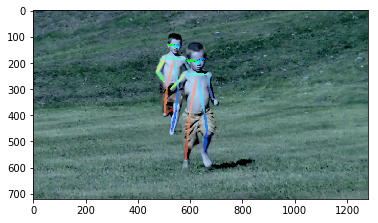

In [23]:
results = {}
results['result'] = result
results['imgname'] = '000004812.jpg' 

imgg = vis_frame(orig_img, results)

%matplotlib inline 
plt.imshow(imgg) 
plt.show() 